In [2]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import utils, callbacks
from tensorflow.keras import utils
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
from tensorflow.keras.callbacks import EarlyStopping


In [3]:
train_folder = './data/asl_alphabet_train/'
all_data = []
for folder in os.listdir(train_folder):
    
    label_folder = os.path.join(train_folder, folder)
    onlyfiles = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    #print(onlyfiles)
    all_data += onlyfiles
data_df = pd.DataFrame(all_data)
data_df

,label,path
0,A,./data/asl_alphabet_train/A\A1.jpg
1,A,./data/asl_alphabet_train/A\A10.jpg
2,A,./data/asl_alphabet_train/A\A100.jpg
3,A,./data/asl_alphabet_train/A\A1000.jpg
4,A,./data/asl_alphabet_train/A\A1001.jpg
...,...,...
86995,Z,./data/asl_alphabet_train/Z\Z995.jpg
86996,Z,./data/asl_alphabet_train/Z\Z996.jpg
86997,Z,./data/asl_alphabet_train/Z\Z997.jpg
86998,Z,./data/asl_alphabet_train/Z\Z998.jpg


In [4]:
x_train,x_holdout = train_test_split(data_df, test_size= 0.10, random_state=42,stratify=data_df[['label']])
x_train,x_test = train_test_split(x_train, test_size= 0.20, random_state=42,stratify=x_train[['label']])

In [5]:
img_width, img_height = 64, 64
batch_size = 128
y_col = 'label'
x_col = 'path'
no_of_classes = len(data_df[y_col].unique())


train_datagen = ImageDataGenerator(rescale = 1/255.0)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=x_train,x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height),class_mode='categorical', batch_size=batch_size,
    shuffle=False
)

validation_datagen = ImageDataGenerator(rescale = 1/255.0)
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=x_test, x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
    shuffle=False
)

holdout_datagen = ImageDataGenerator(rescale = 1/255.0)
holdout_generator = holdout_datagen.flow_from_dataframe(
    dataframe=x_holdout, x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
    shuffle=False
)

Found 62640 validated image filenames belonging to 29 classes.
Found 15660 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.


In [6]:
base_model = ResNet50V2(input_shape=(64, 64, 3), include_top=False, weights="imagenet")
base_model.trainable = False ## Not trainable weights

In [7]:
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 34, 34, 64)   0           ['conv1_conv[0][0]']             
                                                                                         

In [8]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(512, activation='relu')
dropout_layer_1 = layers.Dropout(0.5)
prediction_layer = layers.Dense(29, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dropout_layer_1,
    prediction_layer
])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 29)                14877     
                                                                 
Total params: 27,774,493
Trainable params: 4,209,693
Non-trainable params: 23,564,800
_________________________________________________________________


In [10]:
# to be executed

classes = 29
epochs = 10
learning_rate = 0.0001
early_stop = EarlyStopping(monitor='val_loss',patience=2)

adam = Adam(lr=learning_rate)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator,
                    epochs=epochs,
                    verbose=1,
                    validation_data=validation_generator, shuffle=True,callbacks=[early_stop])

Epoch 1/10
490/490 [==============================] - 2733s 6s/step - loss: 0.7168 - accuracy: 0.7928 - val_loss: 0.1485 - val_accuracy: 0.9540
Epoch 2/10
490/490 [==============================] - 357s 728ms/step - loss: 0.2470 - accuracy: 0.9212 - val_loss: 0.0876 - val_accuracy: 0.9707
Epoch 3/10
490/490 [==============================] - 353s 720ms/step - loss: 0.1851 - accuracy: 0.9410 - val_loss: 0.0580 - val_accuracy: 0.9810
Epoch 4/10
490/490 [==============================] - 341s 695ms/step - loss: 0.1448 - accuracy: 0.9540 - val_loss: 0.0411 - val_accuracy: 0.9871
Epoch 5/10
490/490 [==============================] - 340s 694ms/step - loss: 0.1386 - accuracy: 0.9574 - val_loss: 0.0444 - val_accuracy: 0.9862
Epoch 6/10
490/490 [==============================] - 343s 700ms/step - loss: 0.1427 - accuracy: 0.9573 - val_loss: 0.0415 - val_accuracy: 0.9863


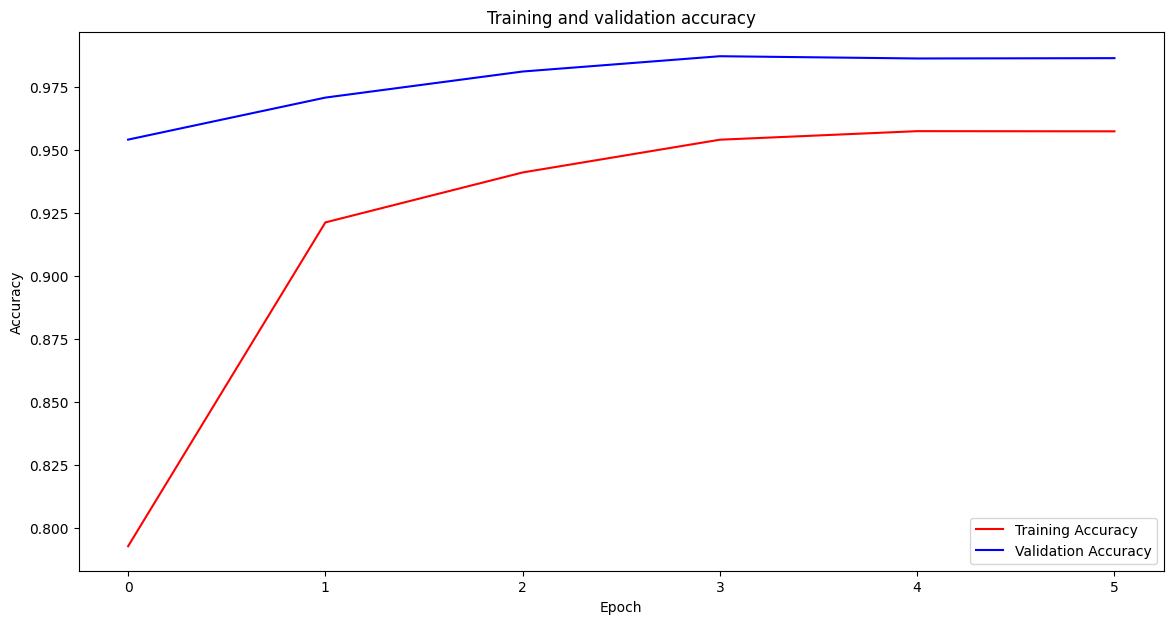

In [11]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

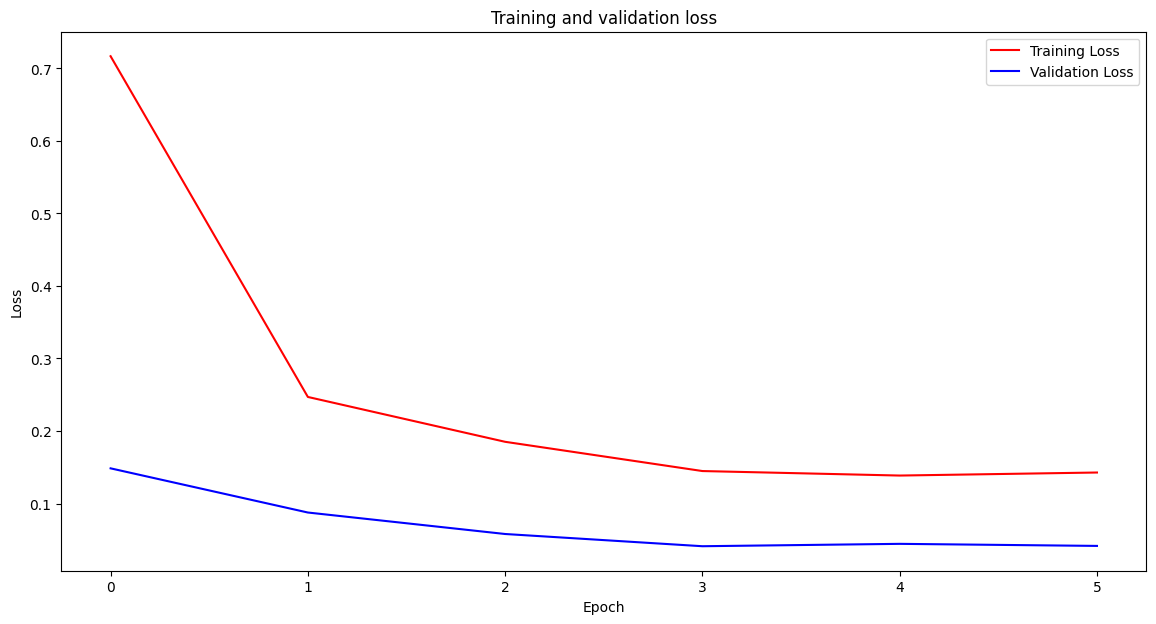

In [12]:
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [13]:
model.save('ResNet50V2.h5')

In [2]:
import cv2
import numpy as np
import os
import mediapipe as mp

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

def draw_styled_landmarks(image, results):
    if results.multi_hand_landmarks:
      for hand_landmarks in results.multi_hand_landmarks:
        mp_drawing.draw_landmarks(
            image,
            hand_landmarks,
            mp_hands.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style())


def extract_keypoints(results):
    if results.multi_hand_landmarks:
      for hand_landmarks in results.multi_hand_landmarks:
        rh = np.array([[res.x, res.y, res.z] for res in hand_landmarks.landmark]).flatten() if hand_landmarks else np.zeros(21*3)
        return(np.concatenate([rh]))
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

actions = np.array(['A','B','C'])

no_sequences = 30

sequence_length = 30

In [ ]:
#Test webCam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
#json_file = open("model.json", "r")
#model_json = json_file.read()
#json_file.close()
#model = model_from_json(model_json)
model = load_model("ResNet50V2.h5")

colors = []
for i in range(0,20):
    colors.append((245,117,16))
print(len(colors))
def prob_viz(res, actions, input_frame, colors,threshold):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame


# 1. New detection variables
sequence = []
sentence = []
accuracy=[]
predictions = []
threshold = 0.8 

cap = cv2.VideoCapture(0)
# cap = cv2.VideoCapture("https://192.168.43.41:8080/video")
# Set mediapipe model 
with mp_hands.Hands(
    model_complexity=0,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as hands:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        cropframe=frame[40:400,0:300]
        # print(frame.shape)
        frame=cv2.rectangle(frame,(0,40),(300,400),255,2)
        # frame=cv2.putText(frame,"Active Region",(75,25),cv2.FONT_HERSHEY_COMPLEX_SMALL,2,255,2)
        image, results = mediapipe_detection(cropframe, hands)
        print(results)
        
        # Draw landmarks
        # draw_styled_landmarks(image, results)
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]

        try: 
            if len(sequence) == 30:
                res = model.predict(np.expand_dims(sequence, axis=0))[0]
                print(actions[np.argmax(res)])
                predictions.append(np.argmax(res))
                
                
            #3. Viz logic
                if np.unique(predictions[-10:])[0]==np.argmax(res): 
                    if res[np.argmax(res)] > threshold: 
                        if len(sentence) > 0: 
                            if actions[np.argmax(res)] != sentence[-1]:
                                sentence.append(actions[np.argmax(res)])
                                accuracy.append(str(res[np.argmax(res)]*100))
                        else:
                            sentence.append(actions[np.argmax(res)])
                            accuracy.append(str(res[np.argmax(res)]*100)) 

                if len(sentence) > 1: 
                    sentence = sentence[-1:]
                    accuracy=accuracy[-1:]

                # Viz probabilities
                # frame = prob_viz(res, actions, frame, colors,threshold)
        except Exception as e:
            # print(e)
            pass
            
        cv2.rectangle(frame, (0,0), (300, 40), (245, 117, 16), -1)
        cv2.putText(frame,"Output: -"+' '.join(sentence)+''.join(accuracy), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', frame)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()